# 🐱🐶 **Cat vs Dog CNN Image Classifier**

- **Author:** Nadia Rozman
- **Date:** January 2026

### **Imports & Configuration**

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import os

### **Global Settings**

In [183]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16  # smaller for sample dataset
EPOCHS = 5       # shorter demo
RANDOM_SEED = 42
PLOT_DIR = "plots"
os.makedirs(PLOT_DIR, exist_ok=True)

### **Data Paths**

In [184]:
TRAIN_DIR = "data_sample/training_set"
TEST_DIR  = "data_sample/test_set"
PREDICT_DIR = "data_sample/single_prediction"

>**⚠️ Dataset Notice:** For full training, replace data_sample/ with the full dataset folder

### **Data Generators**

In [185]:
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [186]:
# Validation/Test generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Wrap in try-except in case folder missing
if os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR):
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="binary",
        seed=RANDOM_SEED
    )

    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="binary",
        seed=RANDOM_SEED
    )

    # Class mapping
    class_indices = train_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    print("Class indices:", class_indices)
else:
    print("Sample dataset not found. Please check the folder structure.")
    train_generator = None
    test_generator = None
    class_indices = {}
    inv_class_indices = {}

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Class indices: {'cats': 0, 'dogs': 1}


### **CNN Model Architecture**

In [187]:
def build_cnn_model(input_shape=(128, 128, 3)):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, 3, activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D(2),

        Conv2D(32, 3, activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D(2),

        Dropout(0.25),

        Flatten(),

        Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.5),

        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_cnn_model()
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,853,473 (7.07 MB)

 Trainable params: 1,853,473 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

### **Early Stopping Setup**

In [188]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    mode="min",
    restore_best_weights=True
)

### **Model Training**

In [189]:
if train_generator and test_generator:
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping]
    )
else:
    history = None
    print("Skipping training because dataset is missing.")

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.5000 - loss: 1.0873 - val_accuracy: 0.5000 - val_loss: 0.9127
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6500 - loss: 1.1058 - val_accuracy: 0.5000 - val_loss: 0.9307
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5000 - loss: 0.9076 - val_accuracy: 0.5000 - val_loss: 1.0019
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6000 - loss: 0.8759 - val_accuracy: 0.5000 - val_loss: 0.8356
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7500 - loss: 0.7565 - val_accuracy: 0.5000 - val_loss: 0.8087


### **Plot Training Curve**

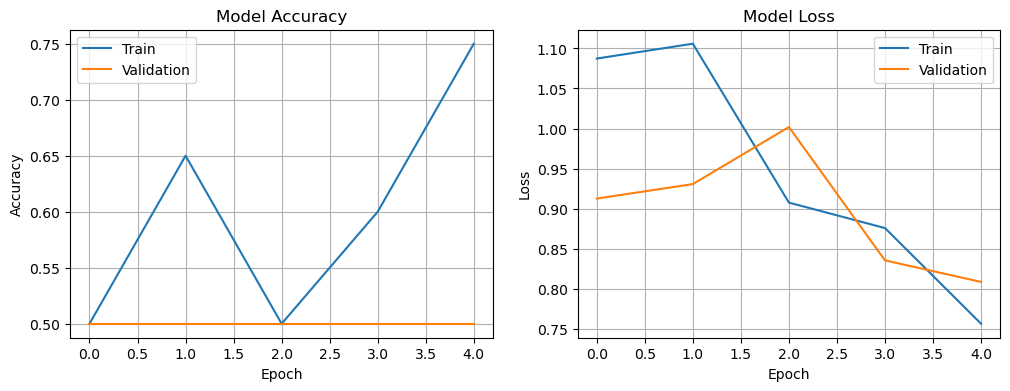

In [ ]:
def plot_training_curves(history, save_path=PLOT_DIR):
    if history is None:
        print("No training history to plot.")
        return
    
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Save images
    plt.savefig(os.path.join(save_path, "cnn_training_curves.png"))
    plt.show()

plot_training_curves(history)

In [191]:
if history:
    final_train_acc = history.history["accuracy"][-1]
    final_val_acc = history.history["val_accuracy"][-1]
    final_train_loss = history.history["loss"][-1]
    final_val_loss = history.history["val_loss"][-1]

    print("Demo Training Results (Sample Dataset):")
    print(f"Training Accuracy: {final_train_acc:.2f}")
    print(f"Validation Accuracy: {final_val_acc:.2f}")
    print(f"Training Loss: {final_train_loss:.2f}")
    print(f"Validation Loss: {final_val_loss:.2f}")
else:
    print("No training results to display (dataset missing).")

Demo Training Results (Sample Dataset):
Training Accuracy: 0.75
Validation Accuracy: 0.50
Training Loss: 0.76
Validation Loss: 0.81


### **Predicting a Single Image**

In [192]:
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img = image.img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    label = inv_class_indices[int(prediction[0][0] > 0.5)]
    return label

# Example prediction using sample images
for img_file in os.listdir(PREDICT_DIR):
    img_path = os.path.join(PREDICT_DIR, img_file)
    print(f"{img_file} --> {predict_image(model, img_path)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
dog2.jpg --> dogs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
dog1.jpg --> cats
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
cat1.jpg --> cats
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cat2.jpg --> cats
